In [2]:
from Gmodel import GProblem

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from functools import partial
import pickle

# Visualising solutions

The code creates sample solution landscapes similar to those reported by Grim et al.

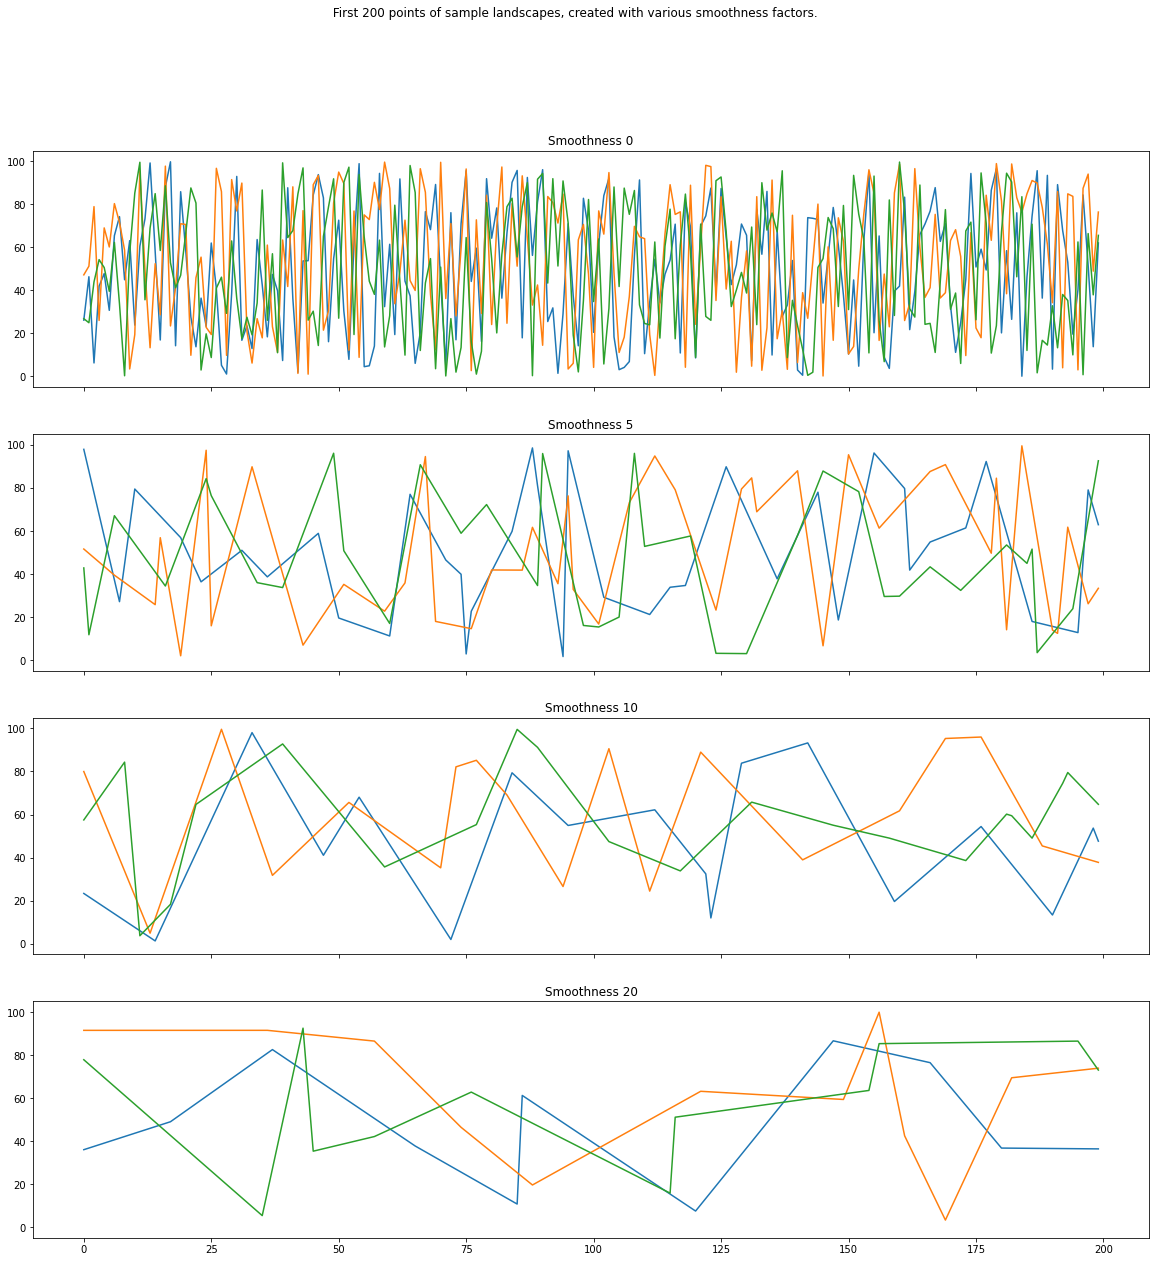

In [40]:
solutions = []
for s in [0, 5, 10, 20]:
        solutions.append(GProblem(2000, 2, 2, 2, s).solution)

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(20, 20), sharex=True, sharey=True)
fig.suptitle(' First 200 points of sample landscapes, created with various smoothness factors.')

ax[0].plot(range(0,200), solutions[0][:200], label='Smoothness 0')
ax[0].set_title("Smoothness 0")
ax[1].plot(range(0,200), solutions[1][:200], label='Smoothness 5')
ax[1].set_title("Smoothness 5")
ax[2].plot(range(0,200), solutions[2][:200], label='Smoothness 10')
ax[2].set_title("Smoothness 10")
ax[3].plot(range(0,200), solutions[3][:200], label='Smoothness 20')
ax[3].set_title("Smoothness 20")

solutions = []
for s in [0, 5, 10, 20]:
        solutions.append(GProblem(2000, 2, 2, 2, s).solution)

ax[0].plot(range(0,200), solutions[0][:200], label='Smoothness 0')
ax[1].plot(range(0,200), solutions[1][:200], label='Smoothness 5')
ax[2].plot(range(0,200), solutions[2][:200], label='Smoothness 10')
ax[3].plot(range(0,200), solutions[3][:200], label='Smoothness 20')

solutions = []
for s in [0, 5, 10, 20]:
        solutions.append(GProblem(2000, 2, 2, 2, s).solution)

ax[0].plot(range(0,200), solutions[0][:200], label='Smoothness 0')
ax[1].plot(range(0,200), solutions[1][:200], label='Smoothness 5')
ax[2].plot(range(0,200), solutions[2][:200], label='Smoothness 10')
ax[3].plot(range(0,200), solutions[3][:200], label='Smoothness 20')

fig.savefig("Figure1.png")


# Grim et al - replication runs

The models in Hong & Page is run 50 times, with three different parameter combinations presented. Here the fourth permutation (large teams with many heuristics) is included, and the number of runs increased to 500. This takes roughly 7 hours on a 4-core 2.4 GHz laptop - so I preferred to do it on Google Cloud Engine, using [pyscript2gce](https://github.com/LukasWallrich/pyscript2gce-production). This ran the following code. 

In [2]:
from mesa.batchrunner import BatchRunnerMP

import httpimport

url = "https://gist.githubusercontent.com/LukasWallrich/42dea3211f0bde452781dd9b69c8199a/raw/3b3a33dc148302bcd32470b8b0c8a26a669af24a"

with httpimport.remote_repo(["Gmodel"], url):
    from Gmodel import GProblem

fixed_params = {"n": 2000,
               "k": 3,
               "N_agents": 10,
               "l": 12
               }
variable_params = {
                   "smoothness": list(range(21))
                   }

batch_run = BatchRunnerMP(GProblem,
                        16,
                        variable_parameters = variable_params,
                        fixed_parameters = fixed_params,
                        iterations=500,
                        max_steps=100,
                        model_reporters={"agent_descriptives": lambda m: m.agent_descriptives,
                        "best_solution": lambda m: m.best_solution})
batch_run.run_all()

out = batch_run.get_model_vars_dataframe()

105it [04:31,  2.58s/it]


In [93]:
with open("Grimmodel_results.pkl",'rb') as f:
    res = pickle.load(f)



In [97]:
def prep_outputs(res):
    if "solution" in res.columns:
        res.rename({"solution": "best_solution"}, inplace=True)
    res = pd.concat([res.drop(["best_solution"], axis = 1), res.best_solution.apply(pd.Series).add_suffix("_solution")], axis = 1)

    def renamer(col, prefix):
        if col.endswith("agent"):
            return col
        else:
            return prefix + col

    res_random = res.agent_descriptives.apply(pd.Series).random.apply(pd.Series).rename(mapper = partial(renamer, prefix = "random_"), axis = "columns")

    res_best = res.agent_descriptives.apply(pd.Series).best.apply(pd.Series).rename(mapper = partial(renamer, prefix = "best_"), axis = "columns")

    res = pd.concat([res.drop(["agent_descriptives"], axis=1), res_best, res_random[res_random.columns[pd.Series(res_random.columns).str.startswith('random_')]]], axis=1)

    res["run_id"] = res.reset_index().index
    res = res.rename(columns={"best_agent": "top_agent"})
    res["gap"] = res["random_solution"] - res["best_solution"]
    return(res)



In [94]:
res = prep_outputs(res)

## Reproducing Figure 2

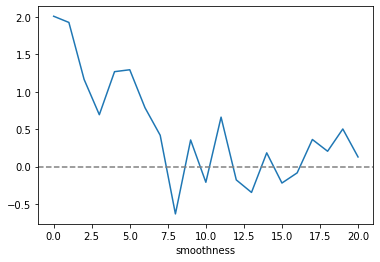

In [91]:

gaps = res[["smoothness", "gap"]].groupby(["smoothness"]).describe().loc[:, (slice(None), ["mean"])]

gaps.columns = gaps.columns.droplevel(0)
gaps.index.name = "smoothness"
gaps.reset_index(inplace=True)

p = gaps.plot.line(x="smoothness", y="mean")

p.axhline(y=0, color='grey', linestyle='--')

p.get_legend().remove()

p.figure.savefig("Fig2.png")


In [155]:
##Could consider older data - but fewer runs made it more erratic

#Add data from earlier runs
#Only 100 runs, very erratic
#with open("Grimmodel_results_9_agents.pkl",'rb') as f:
#    res1 = pickle.load(f)

with open("Grimmodel_results_10_agents.pkl",'rb') as f:
    res1 = pickle.load(f)


In [156]:
index_cols = [ele for ele in list(res1.columns) if ele not in ["team_type", "solution", "team", "NPdiversity", "Cdiversity"]]
res1 = res1.pivot(index=index_cols, columns = "team_type", values="solution").reset_index()

res1["gap"] = res1["random"] - res1["best"]

gaps1 = res1[["smoothness", "gap"]].groupby(["smoothness"]).describe().loc[:, (slice(None), ["mean"])]

gaps1.columns = gaps1.columns.droplevel(0)
gaps1.index.name = "smoothness"
gaps1.reset_index(inplace=True)
gaps1.join(gaps, on="smoothness", lsuffix="a").plot.line(x="smoothness", y=["mean", "meana"])


<AxesSubplot:xlabel='smoothness'>

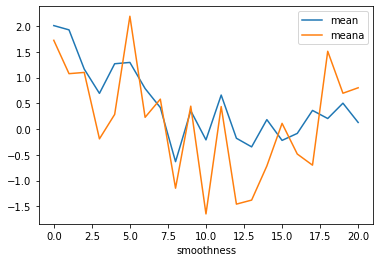

In [68]:
#Pivot so that random and best groups can be easily compared
col_names = res.columns.values.tolist()

def check_var(col_name):
    return not(col_name.find("random_") != -1 or col_name.find("best_") != -1)


id_cols = list(filter(check_var, col_names))

#Drop team averages - otherwise pivoting fails (poss due to memory issues)
out = pd.melt(res.drop(["best_team_average", "random_team_average"], axis=1), id_cols)


In [71]:
out = out.join(out.variable.str.split("_", expand = True)).rename(columns={0:"team_type"}).pivot_table(index=id_cols + ["team_type"], columns=[1], values="value").reset_index()

out["NPdiversity"] = out["NPdiversity"] * 100 #Convert to percentages

out

1,smoothness,Run,n,k,N_agents,l,worst_agent,average_agent,top_agent,run_id,team_type,NPdiversity,solution
0,0,2000,2000,3,10,12,82.114908,83.620803,85.139832,7058,best,79.259259,74.616713
1,0,2000,2000,3,10,12,82.114908,83.620803,85.139832,7058,random,94.814815,98.790335
2,0,2000,2000,3,10,12,82.132242,83.738806,85.356777,7100,best,85.925926,85.175945
3,0,2000,2000,3,10,12,82.132242,83.738806,85.356777,7100,random,91.111111,95.804374
4,0,2000,2000,3,10,12,82.161862,83.606732,85.330345,7198,best,80.000000,93.917148
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,20,2000,2000,3,10,12,72.277795,73.828850,75.092395,3404,random,92.592593,86.758327
20996,20,2000,2000,3,10,12,73.595538,75.068070,76.095844,3851,best,60.740741,97.726199
20997,20,2000,2000,3,10,12,73.595538,75.068070,76.095844,3851,random,90.370370,97.726199
20998,20,2000,2000,3,10,12,74.027240,75.091698,75.999957,3558,best,67.407407,64.454925


In [24]:

out2 = out.join(out.variable.str.split("_", expand = True)).rename(columns={0:"team_type"}).pivot_table(index=id_cols + ["team_type"], columns=[1], values="value")

#

In [27]:
out2["value"]

0        89.376838
1        52.855870
2        65.829238
3        62.471305
4        76.550290
           ...    
62995     0.933333
62996     0.925926
62997     0.896296
62998     0.866667
62999     0.903704
Name: value, Length: 63000, dtype: float64

In [13]:
#Performance and diversity of best versus random teams
summary = res[["team_type", "N_agents", "l", "solution", "NPdiversity", "smoothness"]].groupby(["team_type", "N_agents", "l", "smoothness"]).describe().loc[:, (slice(None), ["mean", "std"])]
summary.to_csv("main_summary.csv")
summary

KeyError: "['team_type', 'solution', 'NPdiversity'] not in index"

In [ ]:
#Describe agents
res[["worst_agent", "top_agent", "best_team_average", "random_team_average", "N_agents", "l", "smoothness"]].groupby(["N_agents", "l", "smoothness"]).describe().loc[:, (slice(None), ["mean", "std"])]